In [1]:
import sys
sys.path.insert(0, "/Users/jdelvalle/git/adtech")
sys.path.insert(0, "/Users/jdelvalle/git/adtech/models/utils")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from scipy.stats import ttest_ind
from scipy.stats import beta

from math import ceil
from ds_utils.db.connectors import HealthcareDW
from time_of_day import calculate_bag_rps

from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import seaborn as sns

In [3]:
query = """
select
    r.session_id,
    r.session_creation_date as date,
    r.product,
    r.zipcode,
    l.subdivision_1_iso_code  as state_code,
    l.metro_code::varchar || l.subdivision_1_iso_code AS dma_state,
    case when r.revenue > 0 then 1 else 0 END AS has_conversion,
    coalesce(r.revenue, 0.0) AS revenue
from (
      select
             session_id,
             product,
             split_part(split_part(landing_page, 'zipcode=',2), '&', 1) as zipcode,
             revenue,
             session_creation_date
      from tron.session_revenue
      where session_creation_date::DATE BETWEEN current_date - 121 AND current_date - 1
      and lower(traffic_source) = 'mediaalpha'
      and domain = 'HC.COM'
      and product in ('HEALTH', 'MEDICARE')
      and zipcode != ''
      ) AS r
left join (
    select maxmind_id, postal_code
    from data_science.maxmind_ipv4_geo_blocks
    group by 1,2
) as b
    on b.postal_code = r.zipcode
left join data_science.maxmind_geo_locations l
    on b.maxmind_id = l.maxmind_id
where l.country_iso_code = 'US'
and l.subdivision_1_iso_code != ''
and l.metro_code != '';
"""

In [4]:
with HealthcareDW() as db_context:
    df = db_context.to_df(query)

INFO:root:query: select r.session_id, r.session_creation_date as date, r.prod... executed in 7.0 seconds


In [5]:
df.head(5)

,session_id,date,product,zipcode,state_code,dma_state,has_conversion,revenue
0,20210423162412.60f72c162cb8,2021-04-23 12:24:12,MEDICARE,07094,NJ,501NJ,0,0.0
1,20210102161135.1326b90d1309,2021-01-02 11:11:35,MEDICARE,07094,NJ,501NJ,0,0.0
2,20201231154900.f5db43b76d60,2020-12-31 10:49:00,HEALTH,07094,NJ,501NJ,0,0.0
3,20210115183804.68d1927f56e6,2021-01-15 13:38:04,MEDICARE,07094,NJ,501NJ,0,0.0
4,20210115183804.68d1927f56e6,2021-01-15 13:38:04,MEDICARE,07094,NJ,501NJ,1,3.0


In [6]:
og_df = df.copy()

In [7]:
len(df['session_id'].unique()), len(df)

(74530, 98663)

In [8]:
counts_df = df.groupby(by=['session_id', 'product', 'zipcode', 'state_code', 'dma_state']).size().reset_index(name='sessions')
quant_df = df.groupby(by=['session_id', 'product', 'zipcode', 'state_code', 'dma_state']).agg({'date': 'min', 'revenue': 'sum', 'has_conversion': 'max'}).reset_index()
df = counts_df.merge(quant_df, how='left', on=['session_id', 'product', 'zipcode', 'state_code', 'dma_state'])

In [9]:
sum(df['zipcode'] == ''), len(df), df['sessions'].sum()

(0, 74693, 98663)

**NOTE**: Get rid of most duplicate rows because of zip codes being associated with more than one city.

In [10]:
df[df['session_id'].isin((df['session_id'].value_counts() > 1).index[(df['session_id'].value_counts() > 1)])].sort_values(by='session_id')

,session_id,product,zipcode,state_code,dma_state,sessions,date,revenue,has_conversion
853,20201229190202.dcaf98146a84,HEALTH,06082,CT,533CT,1,2020-12-29 14:02:02,0.00,0
854,20201229190202.dcaf98146a84,HEALTH,06082,MA,543MA,1,2020-12-29 14:02:02,0.00,0
1257,20201230003509.f3ba205c0c3e,MEDICARE,33442,FL,528FL,2,2020-12-29 19:35:09,7.13,1
1258,20201230003509.f3ba205c0c3e,MEDICARE,33442,FL,548FL,2,2020-12-29 19:35:09,7.13,1
1757,20201230143327.64f912575935,HEALTH,30701,GA,524GA,2,2020-12-30 09:33:27,8.12,1
...,...,...,...,...,...,...,...,...,...
73612,20210427132852.8213fe6d0154,HEALTH,20147,VA,511VA,2,2021-04-27 09:28:52,0.00,0
74160,20210427154640.1d08c5e0b729,MEDICARE,78611,TX,625TX,1,2021-04-27 11:46:40,0.00,0
74161,20210427154640.1d08c5e0b729,MEDICARE,78611,TX,635TX,1,2021-04-27 11:46:40,0.00,0
74560,20210427184033.22a188dcab58,HEALTH,46254,IN,527IN,1,2021-04-27 14:40:33,45.00,1


In [11]:
ma_df = df.groupby(by=['session_id', 'product', 'zipcode', 'state_code', 'dma_state', 'date']).agg({'has_conversion':'max', 'revenue':'max', 'sessions': 'max'}).reset_index()

We still have some duplicates because of zip codes that are associated with more than one DMA.

In [12]:
ma_df['session_id'].value_counts()

20210107163854.212a732a2644    2
20210102155213.7bbc0cdb0b52    2
20210221041304.2e717d909464    2
20210104211102.c7fc6961a6c6    2
20210106195938.15a077e63003    2
                              ..
20210114175419.837fe8eebdcd    1
20201230151150.f8fa6f137413    1
20210308191731.19a5f12bc73c    1
20210224191932.2b227efd5e8c    1
20210331162257.bdd6d60453a8    1
Name: session_id, Length: 74530, dtype: int64

Simple heuristic to get rid of the final (around 10 duplicate rows for 30 day ranges):

In [13]:
ma_df.query('session_id == "20210210162016.04f87d919c67"')

,session_id,product,zipcode,state_code,dma_state,date,has_conversion,revenue,sessions
35394,20210210162016.04f87d919c67,HEALTH,20147,DC,511DC,2021-02-10 11:20:16,0,0.0,1
35395,20210210162016.04f87d919c67,HEALTH,20147,VA,511VA,2021-02-10 11:20:16,0,0.0,2


In [14]:
ma_df = ma_df.groupby(by=['session_id', 'product', 'zipcode', 'date']).agg({'state_code': 'min', 'dma_state': 'min', 'has_conversion':'max', 'revenue':'sum', 'sessions': 'max'}).reset_index()

In [15]:
ma_df.rename(columns={'sessions': 'events'}, inplace=True)

In [16]:
ma_df.head(5)

,session_id,product,zipcode,date,state_code,dma_state,has_conversion,revenue,events
0,20201229050036.2761dbf3d52c,MEDICARE,65588,2020-12-29 00:00:36,MO,619MO,0,0.00,1
1,20201229050104.de9302a353b6,HEALTH,45424,2020-12-29 00:01:04,OH,542OH,0,0.00,2
2,20201229050127.c86ee0cfa1f6,HEALTH,56031,2020-12-29 00:01:27,MN,737MN,1,2.19,1
3,20201229050456.30fb64c200c8,HEALTH,30044,2020-12-29 00:04:56,GA,524GA,0,0.00,1
4,20201229050647.f71648743483,HEALTH,06820,2020-12-29 00:06:47,CT,501CT,1,1.70,1


In [17]:
ma_df['has_conversion'].sum(), len(ma_df)

(23141, 74547)

In [18]:
def calc_location_stats(df, segmentation, min_conversions=0):
    sessions_df = df.groupby(by=segmentation).size().reset_index(name='sessions').copy()

    metrics_df = df.groupby(by=segmentation)[['has_conversion', 'revenue']].sum()\
        .reset_index().rename(columns={'has_conversion': 'conversions'})

    df = sessions_df.merge(metrics_df, how='left', on=segmentation)
    df = df[df['conversions'] >= min_conversions]
    df.reset_index(drop=True, inplace=True)
    
    # Stop weighing high traffic as much
    df['sessions_log'] = np.log10(df['sessions'])
    df['revenue_log'] = np.log10(df['revenue'])
    
    # Calculate raw and bayesian version of stats
    df['rps'] = df['revenue'] / df['sessions']
    # Very hacky way of getting the rps, as revenue is usually higher than sessions
    df['rps_beta'] = 1 / beta.ppf(0.95, df['sessions'] + 1, df['revenue'] - df['sessions'] + 1)
    df.loc[df['rps_beta'].isna(), 'rps_beta'] = df[df['rps_beta'].isna()]['rps']
    
    df['conversion_rate'] = df['conversions'] / df['sessions']
    df['conversion_rate_beta'] = beta.ppf(0.05, df['conversions'] + 1, df['sessions'] - df['conversions'] + 1)
    
    df['rpl'] = df['rps'] * df['conversion_rate']
    df['rpl_beta'] = df['rps_beta'] * df['conversion_rate_beta']
    df.rename(columns={segmentation: 'region'}, inplace=True)
    
    return df

In [19]:
og_ma_df = ma_df.copy()

In [20]:
NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)
end_date = NOW - 61*DAY

In [21]:
ma_df_test = ma_df[ma_df['date'] > end_date]

In [22]:
ma_df = ma_df[ma_df['date'] <= end_date]

# Split setup

In [23]:
u65 = calculate_bag_rps(ma_df.query('product == "HEALTH"'), 'date', 'revenue')
o65 = calculate_bag_rps(ma_df.query('product == "MEDICARE"'), 'date', 'revenue')

In [24]:
SPLIT_REGION='state_code'
MIN_C=30

In [25]:
calc_location_stats(u65.query('state_code == "CA"'), 'dma_state').sort_values(by='sessions', ascending=False).head(8)

,region,sessions,conversions,revenue,sessions_log,revenue_log,rps,rps_beta,conversion_rate,conversion_rate_beta,rpl,rpl_beta
4,803CA,5457,2203,25907.853588,3.736954,4.413431,4.747637,4.654780,0.403702,0.392835,1.916629,1.828560
6,807CA,2268,917,10092.482246,3.355643,4.003998,4.449948,4.317028,0.404321,0.387513,1.799207,1.672905
12,862CA,1407,605,6030.115630,3.148294,3.780326,4.285796,4.124984,0.429993,0.408461,1.842862,1.684894
9,825CA,1175,490,5716.877560,3.070038,3.757159,4.865428,4.662372,0.417021,0.393610,2.028987,1.835157
13,866CA,542,224,2172.535560,2.733999,3.336967,4.008368,3.772118,0.413284,0.379081,1.656595,1.429938
2,800CA,317,133,1506.066400,2.501059,3.177844,4.750998,4.379155,0.419558,0.374956,1.993321,1.641990
10,828CA,294,106,888.798000,2.468347,2.948803,3.023122,2.798752,0.360544,0.316160,1.089969,0.884854
11,855CA,223,83,558.548520,2.348305,2.747061,2.504702,2.305131,0.372197,0.321043,0.932243,0.740047


In [26]:
u65_dma_stats = calc_location_stats(u65.query('dma_state not in ["803CA", "807CA", "825CA", "862CA"]'), SPLIT_REGION, min_conversions=MIN_C)
u65_dma_stats.sort_values(by=['sessions'], ascending=False).head(5)

,region,sessions,conversions,revenue,sessions_log,revenue_log,rps,rps_beta,conversion_rate,conversion_rate_beta,rpl,rpl_beta
22,WA,2493,1135,7613.704852,3.396722,3.881596,3.054033,2.973078,0.455275,0.438935,1.390424,1.304987
4,GA,2404,889,9341.898420,3.380934,3.970435,3.885981,3.775641,0.369800,0.353784,1.437037,1.335761
1,CA,1997,799,7070.213352,3.300378,3.849433,3.540417,3.432247,0.400100,0.382236,1.416521,1.311930
2,CO,1309,561,7215.965144,3.116940,3.858294,5.512578,5.290919,0.428571,0.406268,2.362534,2.149531
7,MD,889,332,3121.666668,2.948902,3.494387,3.511436,3.352535,0.373453,0.347253,1.311357,1.164178


In [27]:
ca_stats = calc_location_stats(u65.query('dma_state in ["803CA", "807CA", "825CA", "862CA"]'), 'dma_state', min_conversions=MIN_C)

In [28]:
u65_dma_stats = pd.concat([u65_dma_stats, ca_stats]).reset_index(drop=True)

In [29]:
u65_dma_stats.sort_values(by='sessions', ascending=True).head(5)

,region,sessions,conversions,revenue,sessions_log,revenue_log,rps,rps_beta,conversion_rate,conversion_rate_beta,rpl,rpl_beta
8,ME,83,37,316.479680,1.919078,2.500346,3.813008,3.277164,0.445783,0.359521,1.699775,1.178208
6,LA,87,39,398.310160,1.939519,2.600221,4.578278,3.927461,0.448276,0.363780,2.052331,1.428731
21,VT,119,51,161.536870,2.075547,2.208272,1.357453,1.267743,0.428571,0.356658,0.581765,0.452151
11,MT,121,57,391.930220,2.082785,2.593209,3.239093,2.869288,0.471074,0.398032,1.525854,1.142068
0,AZ,126,37,266.634472,2.100371,2.425916,2.116147,1.912409,0.293651,0.232533,0.621408,0.444698


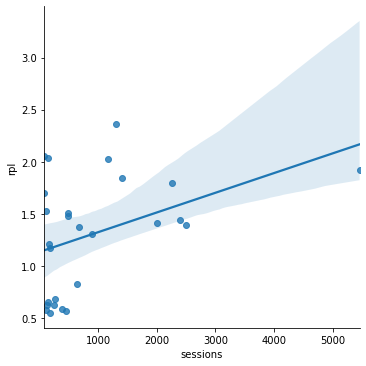

In [30]:
sns.lmplot(x='sessions', y='rpl', data=u65_dma_stats[(~u65_dma_stats['sessions'].isna())], logx=False)

In [31]:
METRICS = ['sessions_log', 'revenue_log', 'rps', 'conversion_rate', 'rpl_beta']

In [32]:
def prepare_data(df, cols, scale_method='max'):
    scaler = None
    if scale_method == 'standard':
        scaler = StandardScaler()
    if scale_method == 'max':
        scaler = MaxAbsScaler()
    scaled_df = df.copy()
    if scaler:
        scaled_df[cols] = scaler.fit_transform(df[cols])

    return scaled_df, scaler

In [33]:
u65_dma_stats[METRICS].describe()

,sessions_log,revenue_log,rps,conversion_rate,rpl_beta
count,27.000000,27.000000,27.000000,27.000000,27.000000
mean,2.656320,3.136411,3.267241,0.392597,1.101596
std,0.520920,0.622582,1.230915,0.047932,0.504716
min,1.919078,2.208272,1.357453,0.293651,0.432316
25%,2.197103,2.610611,2.100754,0.365492,0.526656
50%,2.658965,2.930577,3.466860,0.397496,1.178208
75%,3.093489,3.768742,4.283162,0.428571,1.382246
max,3.736954,4.413431,5.512578,0.471074,2.149531


In [34]:
X, scaler = prepare_data(u65_dma_stats, METRICS)

In [35]:
X[['region'] + METRICS].head(2)

,region,sessions_log,revenue_log,rps,conversion_rate,rpl_beta
0,AZ,0.562054,0.549667,0.383876,0.623364,0.206881
1,CA,0.883173,0.872209,0.642243,0.849335,0.610333


In [36]:
X['final_score'] = X[METRICS].sum(axis=1)

In [37]:
X_final = X.sort_values(by=['final_score'], ascending=False).reset_index(drop=True)

In [38]:
def assign_group(n, length):
    reps = length // n
    init_list = list(range(1,n+1))
    groups = init_list * reps
    i = 1
    while len(groups) < length:
        groups.append(i)
        i += 1
    
    return groups

In [39]:
N = 2

In [40]:
X_final['group'] = assign_group(N, len(X_final))

In [41]:
X_final.sort_values(by=['revenue', 'sessions_log'], ascending=False).head(2)

,region,sessions,conversions,revenue,sessions_log,revenue_log,rps,rps_beta,conversion_rate,conversion_rate_beta,rpl,rpl_beta,final_score,group
1,803CA,5457,2203,25907.853588,1.000000,1.00000,0.861237,4.654780,0.856981,0.392835,1.916629,0.850679,4.568897,2
3,807CA,2268,917,10092.482246,0.897962,0.90723,0.807235,4.317028,0.858295,0.387513,1.799207,0.778265,4.248988,2


In [42]:
X_final.groupby(by='group').agg({'final_score': 'mean'})

,final_score
group,
1,3.363726
2,3.356101


In [43]:
def welches_t_test(first_sample_df, second_sample_df, field='final_score'):
    return ttest_ind(
        first_sample_df[field],
        second_sample_df[field], 
        equal_var=False,
        nan_policy='omit'
    )[1]

### Significance test for both distributions

In [58]:
X_final[['region', 'sessions', 'revenue', 'rpl', 'final_score', 'group']]

,region,sessions,revenue,rpl,final_score,group
0,CO,1309,7215.965144,2.362534,4.618077,1
1,803CA,5457,25907.853588,1.916629,4.568897,2
2,825CA,1175,5716.877560,2.028987,4.294444,1
3,807CA,2268,10092.482246,1.799207,4.248988,2
4,862CA,1407,6030.115630,1.842862,4.173118,1
5,WA,2493,7613.704852,1.390424,3.916026,2
6,GA,2404,9341.898420,1.437037,3.915720,1
7,CA,1997,7070.213352,1.416521,3.857294,2
8,MO,153,755.903740,2.034343,3.719685,1
9,VA,487,2084.616772,1.511808,3.592079,2


In [44]:
welches_t_test(X_final.query('group == 1'), X_final.query('group == 2'), 'final_score')

0.9782640756465824

In [45]:
print(f"{X_final.query('conversions < 1')['revenue'].sum() / X_final['revenue'].sum() * 100}%")

0.0%


## Test on next 30 days

In [46]:
u65_test = calculate_bag_rps(ma_df_test.query('product == "HEALTH"'), 'date', 'revenue')
o65_test = calculate_bag_rps(ma_df_test.query('product == "MEDICARE"'), 'date', 'revenue')

In [47]:
u65_test_stats = calc_location_stats(u65_test.query('dma_state not in ["803CA", "807CA", "825CA", "862CA"]'), SPLIT_REGION, min_conversions=1)

In [48]:
ca_test_stats = calc_location_stats(u65_test.query('dma_state in ["803CA", "807CA", "825CA", "862CA"]'), 'dma_state', min_conversions=1)

In [49]:
u65_test_stats = pd.concat([u65_test_stats, ca_test_stats]).reset_index(drop=True)

In [50]:
#X_test = u65_test_stats.copy()

In [51]:
X_test, scaler_test = prepare_data(u65_test_stats, METRICS)
#X_test[METRICS] = scaler.transform(X_test[METRICS])

In [52]:
X_test['final_score'] = X_test[METRICS].sum(axis=1)

In [53]:
X_test = X_test.merge(X_final[['region', 'group']], how='right', on='region')

In [54]:
welches_t_test(X_test.query('group == 1'), X_test.query('group == 2'), 'final_score')

0.9596535894187064

In [55]:
print(f"{X_test.query('conversions < 1')['revenue'].sum() / X_test['revenue'].sum() * 100}%")

0.0%


## Previous attempts at split (only here as documentation, not completely valid)
### Stable number of conversions analysis

In [1]:
state_prod_df = ma_df.groupby(by=['product', 'state_code']).agg({'revenue': ['count','sum', 'std', 'var', 'mean']}).reset_index()

NameError: name 'ma_df' is not defined

In [ ]:
state_prod_df.columns = state_prod_df.columns.droplevel()

In [ ]:
cols = state_prod_df.columns[2:]
cols = cols.insert(0,'state_code')
cols = cols.insert(0,'product')
state_prod_df.columns = cols

In [ ]:
state_prod_df['std_proportion'] = state_prod_df['std'] / state_prod_df['mean']

In [ ]:
state_prod_df[state_prod_df['count'] < 200][['count', 'std_proportion']].plot.scatter(x='count',y='std_proportion')

In [ ]:
state_prod_df['count'].max()

In [ ]:
sns.lmplot(x='count', y='std_proportion', data=state_prod_df[(state_prod_df['count']<200) & (~state_prod_df['count'].isna())], logx=True)

In [ ]:
dma_stats_df = calc_location_stats(ma_df, ['product', 'state_code', 'dma_state'], 30)
state_stats_df = calc_location_stats(ma_df, ['product', 'state_code'], 1)

In [ ]:
dma_stats_df.sort_values(by=['rps'], ascending=False).head(4)

In [ ]:
state_stats_df.sort_values(by=['rps'], ascending=False).head(5)

In [ ]:
def welches_t_test(parent_sample_df, child_sample_df):

    results = dict()
    for label, df in [('parent', parent_sample_df), ('child', child_sample_df)]:
        
        conversions, revenue = df[['has_conversion', 'revenue']].sum()
        conversions = int(conversions)
        sessions = len(df)
        
        rps = revenue / sessions
        avg_value = revenue / conversions
        conv_rate = conversions / sessions
        
        results[label] = {
            'conversions': conversions,
            'revenue': revenue,
            'sessions': sessions,
            'rps': rps,
            'avg_value': avg_value,
            'conv_rate': conv_rate,
        }
    
    results['pval'] = ttest_ind(
        parent_sample_df['revenue'],
        child_sample_df['revenue'], 
        equal_var=False,
        nan_policy='omit'
    )[1]
    
    return results

In [ ]:
P_VALUE_THRESHOLD = 0.05
MIN_CONVERSIONS = 20

In [ ]:
header = ['product', 'state', 'dma_state', 'state_rps', 'dma_rps', 'pval']
rows = []
for product in ['HEALTH', 'MEDICARE']:
    
    eligible_dmas = dma_stats_df[
        (dma_stats_df['product'] == product) & 
        (dma_stats_df['conversions'] >= MIN_CONVERSIONS)
    ]

    for state_code, dma_state in eligible_dmas[['state_code', 'dma_state']].values:

        df_slice = ma_df[(ma_df['product'] == product) & (ma_df['state_code'] == state_code)]

        # generate sample sets
        state_sample = df_slice[df_slice['dma_state'] != dma_state]
        dma_sample = df_slice[df_slice['dma_state'] == dma_state]

        # if statement two purposes:
        # 1. handles edge cases where a dma_state has only one city, ex. washington dc
        # 2. makes sure dma has enough data after removing city data points
        if len(state_sample) >= MIN_CONVERSIONS:
            
            # run significance testing
            tstats = welches_t_test(state_sample, dma_sample)

            row = [product, state_code, dma_state, tstats['parent']['rps'], tstats['child']['rps'], tstats['pval']]
            rows.append(row)


dma_exemptions = pd.DataFrame(rows, columns=header)

In [ ]:
dma_exemptions[dma_exemptions['pval'] <= P_VALUE_THRESHOLD].sort_values(by='pval')

In [ ]:
dma_exemptions.sort_values(by='pval')

In [ ]:
eligible_dmas = dma_stats_df[dma_stats_df['conversions'] >= MIN_CONVERSIONS]
eligible_dmas[['product', 'rps']].hist(by='product', bins=10, figsize=(15,10), sharey=True)

In [ ]:
product_df = calc_location_stats(ma_df, ['product'])
product_df

In [ ]:
sort_product = 'MEDICARE'
sort_field = 'sessions'

state_order_df = state_stats_df[state_stats_df['product'] == sort_product][['state_code', sort_field]]
state_order_df = state_order_df.set_index(sort_field).sort_index().reset_index()
state_order_df['rank'] = state_order_df.index
state_order_df = state_order_df[['state_code', 'rank']]

plot_df = state_stats_df.merge(state_order_df, how='inner', on='state_code')
plot_df.pivot_table(index=['rank', 'state_code'], columns='product', values=sort_field)\
    .plot.bar(figsize=(15,10), title='Revenue Per Click By State')

In [ ]:
sort_product = 'MEDICARE'
sort_field = 'rps'

state_order_df = state_stats_df[state_stats_df['product'] == sort_product][['state_code', sort_field]]
state_order_df = state_order_df.set_index(sort_field).sort_index().reset_index()
state_order_df['rank'] = state_order_df.index
state_order_df = state_order_df[['state_code', 'rank']]

plot_df = state_stats_df.merge(state_order_df, how='inner', on='state_code')
plot_df.pivot_table(index=['rank', 'state_code'], columns='product', values='rps')\
    .plot.bar(figsize=(15,10), title='Revenue Per Click By State')

In [ ]:
def generate_ranks_df(df, product, sort_field='rps'):
    df = df[df['product'] == product][['state_code', sort_field]]
    df = df.set_index(sort_field).sort_index().reset_index()
    df['rank'] = df.index
    df = df[['state_code', 'rank']]
    return df


medicare_rank = generate_ranks_df(state_stats_df, 'MEDICARE')
health_rank = generate_ranks_df(state_stats_df, 'HEALTH')

medicare_rank.head(3), health_rank.head(3)

# Clustering Algorithm

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [ ]:
scaler = StandardScaler()

In [ ]:
state_stats_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']]

In [ ]:
scaled_state_df = state_stats_df.copy()

In [ ]:
scaled_state_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']] = scaler.fit_transform(state_stats_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']])

In [ ]:
scaled_state_df

In [ ]:
clst = KMeans(n_clusters=2, init='k-means++')

In [ ]:
clst.fit(scaled_state_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']])

In [ ]:
scaled_state_df['cluster'] = clst.labels_

In [ ]:
sns.scatterplot(data=scaled_state_df, x='conversion_rate', y='rpl', hue='cluster', size='sessions')

In [ ]:
clst.score(scaled_state_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']])

In [ ]:
N = 10

In [ ]:
def elbow_analysis(df, cols, n_max):
    scores = []
    for n in range(2, n_max):
        cls = KMeans(n_clusters=n, init='k-means++')
        cls.fit(df[cols])
        scores.append(-1 * cls.score(df[cols]))
    
    return scores

In [ ]:
scores = elbow_analysis(scaled_state_df, ['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl'], N)

In [ ]:
sns.lineplot(x=range(2,N), y=scores)

In [ ]:
cls = KMeans(n_clusters=4, init='k-means++')
cls.fit(scaled_state_df[['sessions', 'conversions', 'revenue', 'rps', 'conversion_rate', 'rpl']])

In [ ]:
scaled_state_df['cluster'] = cls.labels_

In [ ]:
sns.scatterplot(data=scaled_state_df, x='conversion_rate', y='rpl', hue='cluster', size='sessions', palette='colorblind')

In [ ]:
def prepare_data(df, cols, scale_method='standard'):
    scaler = None
    if scale_method == 'standard':
        scaler = StandardScaler()
    if scale_method == 'max':
        scaler = MaxAbsScaler()
    scaled_df = df.copy()
    if scaler:
        scaled_df[cols] = scaler.fit_transform(df[cols])

    return scaled_df, scaler

In [ ]:
N = 20

In [ ]:
cols = ['sessions', 'rps', 'conversion_rate', 'rpl']

In [ ]:
X, scaler = prepare_data(dma_stats_df, cols, scale_method='max')

In [ ]:
scores = elbow_analysis(X, cols, N)

In [ ]:
sns.lineplot(x=range(2,N), y=scores)

In [ ]:
cls = KMeans(n_clusters=2, init='k-means++')
cls.fit(X[cols])

In [ ]:
X['cluster'] = cls.labels_

In [ ]:
sns.scatterplot(data=X, x='conversion_rate', y='rpl', hue='cluster', size='sessions', palette='colorblind')

In [ ]:
X[cols+['cluster']]

In [ ]:
X['cluster'].value_counts()

In [ ]:
X['score'] = X['sessions'] * (X['conversions'] +  X['revenue'] + X['rps'] + X['conversion_rate'] + X['rpl'])

In [ ]:
X.sort_values(by='score', ascending=False).reset_index()

In [ ]:
ma_df